### try real world data 

In [1]:
from sklearn import datasets 
import logging
import sys
import os
%cd ..
from bds.meel import approx_mc2, approx_mc2_core
from bds.rule import Rule
from bds.utils import bin_random , bin_array, randints, solutions_to_dict

#from bds.bb import BranchAndBoundNaive, BranchAndBoundV1, BranchAndBoundV0, BranchAndBoundV2
from logzero import logger
import gmpy2 as gmp
from gmpy2 import mpz , mpfr
from bds.sat.min_freq import construct_min_freq_program
from bds.sat.solver import construct_solver
from bds.gf2 import GF
from bds.rule import Rule
from bds.utils import mpz_set_bits
from tests.utils import assert_dict_allclose, assert_close_mpfr

#from bds.bounds_utils import find_equivalence_classes
import numpy as np 

#from bds.cbb_v2 import * 

logger.setLevel(logging.DEBUG)

num_pts = 500

show_progres = True
rand_seed = 1234

/u/50/ciaperm1/unix/sampling-rashomon-decision-set-code


In [2]:
import pandas as pd
import pickle 

In [3]:
# Load the CSV file using Pandas
data = pd.read_csv('data/compas_test-binary.csv')

# Print the data
data.head()

,sex:Male,age:18-20,age:21-22,age:23-25,age:26-45,age:>45,juvenile-felonies:>0,juvenile-misdemeanors:>0,juvenile-crimes:>0,priors:2-3,priors:=0,priors:=1,priors:>3,current-charge-degree:Misdemeanor,recidivate-within-two-years:1
0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1
2,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
3,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [4]:
# read labels 
f = open("data/compas_test.label", "r")
labels = []
for row in f.readlines(): 
    labels.append(list(map(int, row.split(" ")[1:])))

In [5]:
y = np.array(labels[1], dtype = bool) 

In [6]:
X = data.to_numpy()

In [7]:
assert len(y) == X.shape[0]

In [8]:
# now we need to extract rules 
X_bag = [set([j for j, x in enumerate(row) if x]) for row in X]

In [9]:
from bds.fpgrowth import preprocess_transaction_list, build_fptree, fpgrowth_on_tree

In [10]:
lmbd = 0.1
min_support = lmbd * X.shape[0] / 2

In [11]:
min_support

36.050000000000004

In [4]:
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model

import numpy as np
from scipy.sparse import random

def generate_random_sparse_binary_matrix(rows, cols, density):
    # Generate a random binary matrix with the specified density (percentage of non-zero elements)
    random_matrix = random(rows, cols, density=density, format="csr", dtype=np.float64)
    random_matrix.data = np.array(random_matrix.data >= 0.5, dtype=np.int64)  # Threshold to get binary values
    return random_matrix


class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        self.__solution_count += 1
        for v in self.__variables:
            print('%s=%i' % (v, self.Value(v)), end=' ')
        print()

    def solution_count(self):
        return self.__solution_count
    
    
def compute_truthtable_v2(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    
    return truthtable , support_list
    
    

def solve_sat_with_min_max(n, n_positives, n_negatives, N, P, lambd, epsilon):
    model = cp_model.CpModel()
    #
    m = len(P[0])
    #
    # Constraints for min function
    x = [model.NewBoolVar(f'x{i}') for i in range(m)]  
    zFP = [model.NewBoolVar(f'FP{i}') for i in range(n_negatives)]  # Auxiliary variables z_i with lower bound 0 and upper bound 1
    zFN = [model.NewBoolVar(f'FN{i}') for i in range(n_positives)]
    #
    zFPpre = [model.NewBoolVar(f'preFP{i}') for i in range(n_negatives)]  # Auxiliary variables z_i with lower bound 0 and upper bound 1
    zFNpre = [model.NewBoolVar(f'preFN{i}') for i in range(n_positives)]
    #
    #
    sum_var_positive = model.NewIntVar(0, n_positives, 'sumPos')
    sum_var_negative = model.NewIntVar(0, n_negatives, 'sumNeg')
    sum_var_x = model.NewIntVar(0, m, 'sumx')
    target = model.NewIntVar(0, n, 'target')
    #
    #
    for i in range(n_negatives): 
        model.Add(zFPpre[i] == sum([N[i][j] * x[j] for j in range(m)]))
        model.AddMinEquality(zFP[i], [zFPpre[i], 1])
    #
    #for i in range(n_negatives): 
    #    model.AddMinEquality(zFP[i], [ sum([N[i][j] * x[j] for j in range(m)]) , 1]) # should be either 0 if the innter product is 0 or 1 
    #
    #
    #    
    for i in range(n_positives): 
        model.Add(zFNpre[i] == sum([P[i][j] * x[j] for j in range(m)]))
        model.AddMaxEquality(zFN[i], [ 1-zFNpre[i] , 0]) # also 0 or 1 

        
        
    model.Add(sum_var_positive == sum(zFN))
    #
    model.Add(sum_var_negative == sum(zFP))
    #
    model.Add(sum_var_x == sum(x))
    #
    model.Add( sum_var_positive + sum_var_negative + lambd * n * sum_var_x <= epsilon * n )
    #
    #
    # Create a solver
    #solver = cp_model.CpSolver()
    #
    # Find all feasible solutions
    #count = 0
    #while solver.NextSolution():
    #    count += 1
    #    print(f"Feasible Solution {count}:")
    #    for i in range(1, 6):
    #        print(f"x{i} = {solver.Value(x[i-1])}")
    
    solver = cp_model.CpSolver()
    #solution_printer = VarArraySolutionPrinter([x])
    ## Enumerate all solutions.
    #solver.parameters.enumerate_all_solutions = True
    # Solve.
    status = solver.Solve(model)
    #solver.SearchForAllSolutions(model, solution_printer)
     #count = 0
   

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print("printing solutions... ")
        solution_printer = VarArraySolutionPrinter([x[i] for i in range(len(x))])
        ## Enumerate all solutions.
        solver.parameters.enumerate_all_solutions = True
        # Solve.. 
        status = solver.Solve(model, solution_printer)
                #print('x = %i' % solver.Value(x[0]))
    else:
        print('No solution found.')

    
    return model

In [5]:
def custom_print(*args, **kwargs):
    # You can log the output to a file or ignore it altogether
    pass

# Redefine the print function inside your function
original_print = print
print = custom_print

In [6]:
from bds.rule import Rule
from time import time

def compute_truthtable(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    return truthtable
    

In [32]:
from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random

all_n_rules = [] 
lmbd = 1 
ub = 3
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

show_progres = True

#all_averages_times_MC = [] 
#all_averages_times_GT = [] 


#all_averages_counts_MC = [] 
#all_averages_counts_GT = []

#all_averages_times_SAT = []

#for min_support in [ 50 ][::-1]: 
 
for min_support in [ 30 ][::-1]: 
 
    
    
    ordered_input_data = preprocess_transaction_list(
        X_bag, min_support
    )
    tree = build_fptree(ordered_input_data)
    frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))
    
    all_n_rules.append(len(frequent_itemsets)) 
    
    # Now create rules 
    rules = [] 
    for i,itemset in enumerate(frequent_itemsets):
        tt = compute_truthtable(X,itemset)
        this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
        # we need the truthtable for this itemset 
        rules.append(this_Rule)
            
    pickle.dump(rules, open("rules/rules_compas_05_" + str(len(rules)), "wb" ))
    
    # approxMC
    all_times_MC = [] 
    all_counts_MC = [] 
    
    all_times_GT = [] 
    all_counts_GT = [] 
    
    all_times_SAT = [] 
    
    
    for _ in range(n_reps):
    
        t = time.time() 
        test_cnt = approx_mc2(
                    rules, y, lmbd=lmbd, ub=ub,
                    delta=delta, eps=eps, rand_seed=rand_seed, show_progress=show_progres,
                    parallel=False, log_level=logging.WARN
                )
        
        elapsed = time.time() - t 
        all_times_MC.append(elapsed) 
        all_counts_MC.append(test_cnt)

        
        # complete enumeration 
        t = time.time() 
        ref_count = get_ground_truth_count(rules, y, lmbd, ub)
        elapsed = time.time() - t 
        all_times_GT.append(elapsed) 
        all_counts_GT.append(ref_count) 
        

        # sat 
        PD = X[y]
        ND = X[~y]

        N = np.zeros((ND.shape[0], len(frequent_itemsets)))
        P = np.zeros((PD.shape[0], len(frequent_itemsets)))

        # create map 
        positive_counter = 0 
        negative_counter = 0 
        map_positive = dict() 
        map_negative = dict() 

        for i in range(X.shape[0]): 
            if y[i]: 
                map_positive[i] = positive_counter 
                positive_counter+=1 
            else: 
                map_negative[i] = negative_counter
                negative_counter+=1 


        for i,itemset in enumerate(frequent_itemsets):
            tt , support_list = compute_truthtable_v2(X,itemset)
            #this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
            # we need the truthtable for this itemset 
            #rules.append(this_Rule)

            for example in support_list: 
                if y[example]: 
                    P[map_positive[example], i] = 1 
                else: 
                    N[map_negative[example], i] = 1 


        # record time 
        t = time.time() 
        n = X.shape[0] 
        rows_positive = P.shape[0] 
        rows_negative = N.shape[0]
        solutions = solve_sat_with_min_max(n, rows_positive, rows_negative, N, P, lambd=lmbd, epsilon = ub) #solve_integer_program(n, m, N, P, lmbd, ub)
        elapsed = time.time() - t 
        all_times_SAT.append(elapsed)


       
    
    all_averages_times_MC.append(np.mean(all_times_MC))
    all_averages_times_GT.append(np.mean(all_times_GT))
    
    all_averages_counts_MC.append(np.mean(all_counts_MC))
    all_averages_counts_GT.append(np.mean(all_counts_GT))
    
    all_averages_times_SAT.append(np.mean(all_times_SAT))
    
    
pickle.dump(all_averages_times_MC, open("all_averages_times_MC_withSAT_2_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_times_GT, open("all_averages_times_GT_withSAT_2_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_counts_MC, open("all_averages_counts_MC_withSAT_2_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_counts_GT, open("all_averages_counts_GT_withSAT_2_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_times_SAT, open("all_averages_times_SAT_withSAT_2_" + str(len(rules)), "wb" ))


    # sampleTree
    #bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=4, k=150) 
    #Z = bb.runST()

[D 230814 13:38:06 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230814 13:38:06 meel:365] thresh = 72.95
[D 230814 13:38:06 bb:53] calling BranchAndBoundNaive with ub=3, lmbd=1
[D 230814 13:38:06 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230814 13:38:06 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230814 13:38:06 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:06 meel:280] initial solving under 103 constraints
[D 230814 13:38:06 cbb:160] setting up the parity constraint system
[D 230814 13:38:06 cbb_v2:328] abort the search since the linear system is not solvable
[D 230814 13:38:06 meel:283] solving takes 0.02 secs
[D 230814 13:38:06 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230814 13:38:06 meel:98] calling log_search with thresh=72
[D 230814 13:38:06 bb:5

time_cost_info: 
|1|0.011007435001374688|
|2|0.011708067002473399|
|3|0.016038542002206668|
|4|0.02545474499493139|
|8|0.09095706100197276|
|6|0.037857489005546086|
|7|0.08407112900022184|
m (to return): 7
time_cost_info: 
|7|0.0809976309974445|
|6|0.03337559299689019|


[D 230814 13:38:06 meel:149] search tree size: 719
[D 230814 13:38:06 meel:150] number of prefix evaluations: 25770
[D 230814 13:38:06 meel:152] solving takes 0.11 secs
[D 230814 13:38:06 meel:198] |Y| < thresh (41 < 72)
[D 230814 13:38:06 meel:137] ---- solve m = 6----
[D 230814 13:38:06 cbb:160] setting up the parity constraint system
[D 230814 13:38:06 meel:149] search tree size: 743
[D 230814 13:38:06 meel:150] number of prefix evaluations: 30404
[D 230814 13:38:06 meel:152] solving takes 0.03 secs
[D 230814 13:38:06 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:06 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:06 meel:411] running approx_mc2_core takes 0.17s
[D 230814 13:38:06 meel:414] num_cells: 128, num_sols: 41
  9%|████▏                                       | 3/32 [00:00<00:05,  5.06it/s][D 230814 13:38:06 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:06 meel:280] initial solving under 103 constraints
[D 230814 13:38:06 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.10518516899901442|
|6|0.031051799000124447|
m (to return): 7
time_cost_info: 
|7|0.09797409799648449|
|6|0.03985034899960738|


[D 230814 13:38:07 meel:283] solving takes 0.03 secs
[D 230814 13:38:07 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230814 13:38:07 meel:98] calling log_search with thresh=72
[D 230814 13:38:07 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:07 meel:137] ---- solve m = 7----
[D 230814 13:38:07 cbb:160] setting up the parity constraint system
[D 230814 13:38:07 meel:149] search tree size: 701
[D 230814 13:38:07 meel:150] number of prefix evaluations: 24079
[D 230814 13:38:07 meel:152] solving takes 0.10 secs
[D 230814 13:38:07 meel:198] |Y| < thresh (53 < 72)
[D 230814 13:38:07 meel:137] ---- solve m = 6----
[D 230814 13:38:07 cbb:160] setting up the parity constraint system
[D 230814 13:38:07 meel:149] search tree size: 750
[D 230814 13:38:07 meel:150] number of prefix evaluations: 27341
[D 230814 13:38:07 meel:152] solving takes 0.04 secs
[D 230814 13:38:07 meel:162] |Y| >= thresh (72 >= 72)
[D 230814

m (to return): 7
time_cost_info: 
|7|0.09840002699638717|
|6|0.0356955979950726|
m (to return): 7
time_cost_info: 
|7|0.10279686099966057|
|6|0.03462737699737772|


[D 230814 13:38:07 meel:414] num_cells: 128, num_sols: 56
 19%|████████▎                                   | 6/32 [00:01<00:04,  5.26it/s][D 230814 13:38:07 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:07 meel:280] initial solving under 103 constraints
[D 230814 13:38:07 cbb:160] setting up the parity constraint system
[D 230814 13:38:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230814 13:38:07 meel:283] solving takes 0.03 secs
[D 230814 13:38:07 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230814 13:38:07 meel:98] calling log_search with thresh=72
[D 230814 13:38:07 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:07 meel:137] ---- solve m = 7----
[D 230814 13:38:07 cbb:160] setting up the parity constraint system
[D 230814 13:38:07 meel:149] search tree size: 702
[D 230814 13:38:07 meel:150] number of prefix evaluations: 24074
[D 230814 13:38:

m (to return): 7
time_cost_info: 
|7|0.20899586300220108|
|6|0.03411961299570976|
m (to return): 7
time_cost_info: 
|7|0.09434797200083267|
|6|0.03691581400198629|


[D 230814 13:38:07 meel:283] solving takes 0.02 secs
[D 230814 13:38:07 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230814 13:38:07 meel:98] calling log_search with thresh=72
[D 230814 13:38:07 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:07 meel:137] ---- solve m = 7----
[D 230814 13:38:07 cbb:160] setting up the parity constraint system
[D 230814 13:38:08 meel:149] search tree size: 730
[D 230814 13:38:08 meel:150] number of prefix evaluations: 25777
[D 230814 13:38:08 meel:152] solving takes 0.10 secs
[D 230814 13:38:08 meel:198] |Y| < thresh (40 < 72)
[D 230814 13:38:08 meel:137] ---- solve m = 6----
[D 230814 13:38:08 cbb:160] setting up the parity constraint system
[D 230814 13:38:08 meel:149] search tree size: 749
[D 230814 13:38:08 meel:150] number of prefix evaluations: 29868
[D 230814 13:38:08 meel:152] solving takes 0.04 secs
[D 230814 13:38:08 meel:162] |Y| >= thresh (72 >= 72)
[D 230814

m (to return): 7
time_cost_info: 
|7|0.10161126100138063|
|6|0.0381187359962496|
m (to return): 7
time_cost_info: 
|7|0.099929071002407|
|6|0.03713894700194942|


[D 230814 13:38:08 meel:283] solving takes 0.02 secs
[D 230814 13:38:08 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230814 13:38:08 meel:98] calling log_search with thresh=72
[D 230814 13:38:08 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:08 meel:137] ---- solve m = 7----
[D 230814 13:38:08 cbb:160] setting up the parity constraint system
[D 230814 13:38:08 meel:149] search tree size: 696
[D 230814 13:38:08 meel:150] number of prefix evaluations: 24076
[D 230814 13:38:08 meel:152] solving takes 0.12 secs
[D 230814 13:38:08 meel:198] |Y| < thresh (47 < 72)
[D 230814 13:38:08 meel:137] ---- solve m = 6----
[D 230814 13:38:08 cbb:160] setting up the parity constraint system
[D 230814 13:38:08 meel:149] search tree size: 751
[D 230814 13:38:08 meel:150] number of prefix evaluations: 28087
[D 230814 13:38:08 meel:152] solving takes 0.04 secs
[D 230814 13:38:08 meel:162] |Y| >= thresh (72 >= 72)
[D 230814

m (to return): 7
time_cost_info: 
|7|0.12274057600006927|
|6|0.04343627999332966|
m (to return): 7
time_cost_info: 
|7|0.09063058500032639|
|6|0.047106213998631574|


[D 230814 13:38:08 cbb_v2:328] abort the search since the linear system is not solvable
[D 230814 13:38:08 meel:283] solving takes 0.02 secs
[D 230814 13:38:08 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230814 13:38:08 meel:98] calling log_search with thresh=72
[D 230814 13:38:08 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:08 meel:137] ---- solve m = 7----
[D 230814 13:38:08 cbb:160] setting up the parity constraint system
[D 230814 13:38:08 meel:149] search tree size: 694
[D 230814 13:38:08 meel:150] number of prefix evaluations: 24071
[D 230814 13:38:08 meel:152] solving takes 0.09 secs
[D 230814 13:38:08 meel:198] |Y| < thresh (46 < 72)
[D 230814 13:38:08 meel:137] ---- solve m = 6----
[D 230814 13:38:08 cbb:160] setting up the parity constraint system
[D 230814 13:38:08 meel:149] search tree size: 710
[D 230814 13:38:08 meel:150] number of prefix evaluations: 27725
[D 230814 13:38:08 meel:152]

m (to return): 7
time_cost_info: 
|7|0.08763382400502451|
|6|0.032279687002301216|
m (to return): 7
time_cost_info: 
|7|0.07766034499945818|
|6|0.03333020499849226|


[D 230814 13:38:09 meel:149] search tree size: 759
[D 230814 13:38:09 meel:150] number of prefix evaluations: 25795
[D 230814 13:38:09 meel:152] solving takes 0.09 secs
[D 230814 13:38:09 meel:198] |Y| < thresh (56 < 72)
[D 230814 13:38:09 meel:137] ---- solve m = 6----
[D 230814 13:38:09 cbb:160] setting up the parity constraint system
[D 230814 13:38:09 meel:149] search tree size: 756
[D 230814 13:38:09 meel:150] number of prefix evaluations: 29383
[D 230814 13:38:09 meel:152] solving takes 0.03 secs
[D 230814 13:38:09 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:09 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:09 meel:411] running approx_mc2_core takes 0.16s
[D 230814 13:38:09 meel:414] num_cells: 128, num_sols: 56
 47%|████████████████████▏                      | 15/32 [00:02<00:02,  5.96it/s][D 230814 13:38:09 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:09 meel:280] initial solving under 103 constraints
[D 230814 13:38:09 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.09226660399872344|
|6|0.031911591002426576|
m (to return): 7
time_cost_info: 
|7|0.08860918899881653|
|6|0.030668298997625243|


[D 230814 13:38:09 meel:149] search tree size: 727
[D 230814 13:38:09 meel:150] number of prefix evaluations: 25768
[D 230814 13:38:09 meel:152] solving takes 0.09 secs
[D 230814 13:38:09 meel:198] |Y| < thresh (47 < 72)
[D 230814 13:38:09 meel:137] ---- solve m = 6----
[D 230814 13:38:09 cbb:160] setting up the parity constraint system
[D 230814 13:38:09 meel:149] search tree size: 765
[D 230814 13:38:09 meel:150] number of prefix evaluations: 29968
[D 230814 13:38:09 meel:152] solving takes 0.04 secs
[D 230814 13:38:09 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:09 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:09 meel:411] running approx_mc2_core takes 0.16s
[D 230814 13:38:09 meel:414] num_cells: 128, num_sols: 47
 53%|██████████████████████▊                    | 17/32 [00:03<00:02,  5.99it/s][D 230814 13:38:09 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:09 meel:280] initial solving under 103 constraints
[D 230814 13:38:09 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.08936931600328535|
|6|0.039140122004027944|
m (to return): 7
time_cost_info: 
|7|0.08967002099961974|
|6|0.03377822300535627|


[D 230814 13:38:09 meel:149] search tree size: 732
[D 230814 13:38:09 meel:150] number of prefix evaluations: 25777
[D 230814 13:38:09 meel:152] solving takes 0.11 secs
[D 230814 13:38:09 meel:198] |Y| < thresh (43 < 72)
[D 230814 13:38:09 meel:137] ---- solve m = 6----
[D 230814 13:38:09 cbb:160] setting up the parity constraint system
[D 230814 13:38:09 meel:149] search tree size: 761
[D 230814 13:38:09 meel:150] number of prefix evaluations: 30255
[D 230814 13:38:09 meel:152] solving takes 0.04 secs
[D 230814 13:38:09 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:09 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:09 meel:411] running approx_mc2_core takes 0.18s
[D 230814 13:38:09 meel:414] num_cells: 128, num_sols: 43
 59%|█████████████████████████▌                 | 19/32 [00:03<00:02,  5.85it/s][D 230814 13:38:09 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:09 meel:280] initial solving under 103 constraints
[D 230814 13:38:09 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.10927163699670928|
|6|0.037834766997548286|
m (to return): 7
time_cost_info: 
|7|0.0964527099931729|
|6|0.02783395400183508|


[D 230814 13:38:10 meel:149] search tree size: 738
[D 230814 13:38:10 meel:150] number of prefix evaluations: 25781
[D 230814 13:38:10 meel:152] solving takes 0.11 secs
[D 230814 13:38:10 meel:198] |Y| < thresh (49 < 72)
[D 230814 13:38:10 meel:137] ---- solve m = 6----
[D 230814 13:38:10 cbb:160] setting up the parity constraint system
[D 230814 13:38:10 meel:149] search tree size: 758
[D 230814 13:38:10 meel:150] number of prefix evaluations: 29477
[D 230814 13:38:10 meel:152] solving takes 0.04 secs
[D 230814 13:38:10 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:10 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:10 meel:411] running approx_mc2_core takes 0.18s
[D 230814 13:38:10 meel:414] num_cells: 128, num_sols: 49
 66%|████████████████████████████▏              | 21/32 [00:03<00:01,  5.79it/s][D 230814 13:38:10 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:10 meel:280] initial solving under 103 constraints
[D 230814 13:38:10 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.10740997600078117|
|6|0.042193517001578584|
m (to return): 7
time_cost_info: 
|7|0.10263412800122751|
|6|0.02835143199627055|


[D 230814 13:38:10 meel:149] search tree size: 679
[D 230814 13:38:10 meel:150] number of prefix evaluations: 23973
[D 230814 13:38:10 meel:152] solving takes 0.08 secs
[D 230814 13:38:10 meel:198] |Y| < thresh (45 < 72)
[D 230814 13:38:10 meel:137] ---- solve m = 6----
[D 230814 13:38:10 cbb:160] setting up the parity constraint system
[D 230814 13:38:10 meel:149] search tree size: 748
[D 230814 13:38:10 meel:150] number of prefix evaluations: 28354
[D 230814 13:38:10 meel:152] solving takes 0.04 secs
[D 230814 13:38:10 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:10 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:10 meel:411] running approx_mc2_core takes 0.15s
[D 230814 13:38:10 meel:414] num_cells: 128, num_sols: 45
 72%|██████████████████████████████▉            | 23/32 [00:04<00:01,  6.06it/s][D 230814 13:38:10 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:10 meel:280] initial solving under 103 constraints
[D 230814 13:38:10 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.07682618499529781|
|6|0.04025689999980386|
m (to return): 7
time_cost_info: 
|7|0.07884642299904954|
|6|0.03284901400184026|


[D 230814 13:38:10 meel:149] search tree size: 694
[D 230814 13:38:10 meel:150] number of prefix evaluations: 24072
[D 230814 13:38:10 meel:152] solving takes 0.08 secs
[D 230814 13:38:10 meel:198] |Y| < thresh (49 < 72)
[D 230814 13:38:10 meel:137] ---- solve m = 6----
[D 230814 13:38:10 cbb:160] setting up the parity constraint system
[D 230814 13:38:10 meel:149] search tree size: 701
[D 230814 13:38:10 meel:150] number of prefix evaluations: 26850
[D 230814 13:38:10 meel:152] solving takes 0.03 secs
[D 230814 13:38:10 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:10 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:10 meel:411] running approx_mc2_core takes 0.14s
[D 230814 13:38:10 meel:414] num_cells: 128, num_sols: 49
 78%|█████████████████████████████████▌         | 25/32 [00:04<00:01,  6.54it/s][D 230814 13:38:10 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:10 meel:280] initial solving under 103 constraints
[D 230814 13:38:10 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.0786279599997215|
|6|0.029806998994899914|
m (to return): 7
time_cost_info: 
|7|0.07564124900090974|
|6|0.02878681500442326|


[D 230814 13:38:11 meel:149] search tree size: 707
[D 230814 13:38:11 meel:150] number of prefix evaluations: 25691
[D 230814 13:38:11 meel:152] solving takes 0.08 secs
[D 230814 13:38:11 meel:198] |Y| < thresh (41 < 72)
[D 230814 13:38:11 meel:137] ---- solve m = 6----
[D 230814 13:38:11 cbb:160] setting up the parity constraint system
[D 230814 13:38:11 meel:149] search tree size: 733
[D 230814 13:38:11 meel:150] number of prefix evaluations: 30063
[D 230814 13:38:11 meel:152] solving takes 0.04 secs
[D 230814 13:38:11 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:11 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:11 meel:411] running approx_mc2_core takes 0.15s
[D 230814 13:38:11 meel:414] num_cells: 128, num_sols: 41
 84%|████████████████████████████████████▎      | 27/32 [00:04<00:00,  6.66it/s][D 230814 13:38:11 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:11 meel:280] initial solving under 103 constraints
[D 230814 13:38:11 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.08192451300419634|
|6|0.037942540999210905|
m (to return): 7
time_cost_info: 
|7|0.07861702800437342|
|6|0.028475099003117066|


[D 230814 13:38:11 meel:149] search tree size: 693
[D 230814 13:38:11 meel:150] number of prefix evaluations: 24074
[D 230814 13:38:11 meel:152] solving takes 0.08 secs
[D 230814 13:38:11 meel:198] |Y| < thresh (39 < 72)
[D 230814 13:38:11 meel:137] ---- solve m = 6----
[D 230814 13:38:11 cbb:160] setting up the parity constraint system
[D 230814 13:38:11 meel:149] search tree size: 761
[D 230814 13:38:11 meel:150] number of prefix evaluations: 28561
[D 230814 13:38:11 meel:152] solving takes 0.04 secs
[D 230814 13:38:11 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:11 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:11 meel:411] running approx_mc2_core takes 0.14s
[D 230814 13:38:11 meel:414] num_cells: 128, num_sols: 39
 91%|██████████████████████████████████████▉    | 29/32 [00:05<00:00,  6.82it/s][D 230814 13:38:11 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:11 meel:280] initial solving under 103 constraints
[D 230814 13:38:11 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.07751092699618312|
|6|0.035618959002022166|
m (to return): 7
time_cost_info: 
|7|0.08066968100320082|
|6|0.03245684700232232|


[D 230814 13:38:11 meel:149] search tree size: 702
[D 230814 13:38:11 meel:150] number of prefix evaluations: 24086
[D 230814 13:38:11 meel:152] solving takes 0.07 secs
[D 230814 13:38:11 meel:198] |Y| < thresh (43 < 72)
[D 230814 13:38:11 meel:137] ---- solve m = 6----
[D 230814 13:38:11 cbb:160] setting up the parity constraint system
[D 230814 13:38:11 meel:149] search tree size: 699
[D 230814 13:38:11 meel:150] number of prefix evaluations: 27652
[D 230814 13:38:11 meel:152] solving takes 0.03 secs
[D 230814 13:38:11 meel:162] |Y| >= thresh (72 >= 72)
[D 230814 13:38:11 meel:174] big_cell[7]=0, return 7
[D 230814 13:38:11 meel:411] running approx_mc2_core takes 0.13s
[D 230814 13:38:11 meel:414] num_cells: 128, num_sols: 43
 97%|█████████████████████████████████████████▋ | 31/32 [00:05<00:00,  6.99it/s][D 230814 13:38:11 bb:53] calling ConstrainedBranchAndBound with ub=3, lmbd=1
[D 230814 13:38:11 meel:280] initial solving under 103 constraints
[D 230814 13:38:11 cbb:160] setting u

m (to return): 7
time_cost_info: 
|7|0.07206307200249285|
|6|0.03186090400413377|
m (to return): 7
time_cost_info: 
|7|0.07736516299337381|
|6|0.037149422998481896|


In [46]:
def move_last_to_first(lst):
    if len(lst) > 0:
        last_element = lst.pop()  # Remove the last element
        lst.insert(0, last_element)  # Insert the last element at the beginning



In [67]:
all_averages_times_MC

[5.526592016220093,
 2.789334774017334,
 1.8542969226837158,
 1.852482557296753,
 1.4963412284851074]

In [68]:
all_averages_times_GT

[0.1308443546295166,
 0.044525861740112305,
 0.014891624450683594,
 0.013513803482055664,
 0.007465839385986328]

In [50]:
move_last_to_first(all_averages_times_MC)
move_last_to_first(all_averages_times_GT)

/tmp/ipykernel_41570/2766877336.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
/tmp/ipykernel_41570/2766877336.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])


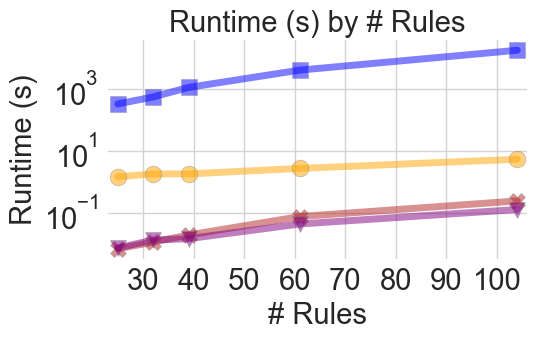

In [78]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams["mathtext.default"] = "regular"

plt.figure(figsize=((5.5, 3.5)))
# Plot the first data on the first subplot
#ax1.plot([61 , 77, 104], y1, color='red')
#ax1.set_title('Plot 1')

x = [25, 32, 39, 61 , 104]

plt.xlim(x[0]-2, x[-1]+2)

#print(times_MC)

plt.plot(x, times_by_rules,  marker='X', color = "firebrick" , linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
# this is below 

plt.plot(x, all_averages_times_MC[::-1], marker='o', color = "orange" ,   linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_GT[::-1], marker='v', 
        color = "purple",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_SAT[::-1], marker='s', 
        color = "blue",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

#ax1.legend(fontsize = 16)

#ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
plt.title("Runtime (s) by # Rules" , fontsize = 21)

plt.xlabel(" # Rules ", fontsize = 21 )

plt.ylabel(" Runtime (s) " , fontsize = 21 ) 

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(fontsize=21)  # Change the fontsize to your desired value
plt.yticks(fontsize=21)

hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()



plt.savefig("compas_runtime_vs_n_rules_with_SAT" +  "_log.pdf") 

# Display the plots
plt.show()


/tmp/ipykernel_41570/683846798.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
/tmp/ipykernel_41570/683846798.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])


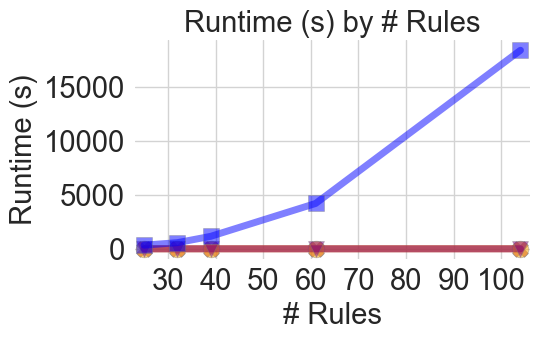

In [79]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams["mathtext.default"] = "regular"

plt.figure(figsize=((5.5, 3.5)))
# Plot the first data on the first subplot
#ax1.plot([61 , 77, 104], y1, color='red')
#ax1.set_title('Plot 1')

x = [25, 32, 39, 61 , 104]

plt.xlim(x[0]-2, x[-1]+2)

#print(times_MC)

plt.plot(x, times_by_rules,  marker='X', color = "firebrick" , linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
# this is below 

plt.plot(x, all_averages_times_MC[::-1], marker='o', color = "orange" ,   linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_GT[::-1], marker='v', 
        color = "purple",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_SAT[::-1], marker='s', 
        color = "blue",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

#ax1.legend(fontsize = 16)

#ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
plt.title("Runtime (s) by # Rules" , fontsize = 21)

plt.xlabel(" # Rules ", fontsize = 21 )

plt.ylabel(" Runtime (s) " , fontsize = 21 ) 

#plt.yscale('log')  # Set y-axis to logarithmic scale

plt.xticks(fontsize=21)  # Change the fontsize to your desired value
plt.yticks(fontsize=21)

hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()



plt.savefig("compas_runtime_vs_n_rules_with_SAT" +  ".pdf") 

# Display the plots
plt.show()


In [120]:
data.shape

(8124, 117)

#### Now with mushroom dataset


In [7]:
# Load the CSV file using Pandas
dataset = "mushrooms"
data = pd.read_csv('data/mushrooms.csv')

sample_size = 1000 
data = data.sample(n=sample_size)


# Print the data
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
251,p,x,s,n,t,p,f,c,n,p,...,s,w,w,p,w,o,p,n,s,g
2085,e,f,f,g,f,n,f,w,b,n,...,s,w,w,p,w,o,e,k,s,g
738,e,x,s,w,t,l,f,c,b,g,...,s,w,w,p,w,o,p,k,s,g
3012,e,f,y,e,t,n,f,c,b,u,...,s,p,g,p,w,o,p,n,y,d
4347,p,f,f,g,f,f,f,c,b,h,...,k,p,p,p,w,o,l,h,v,g


In [8]:
y = data["class"]
data = data.drop('class', axis=1)
data = pd.get_dummies(data).astype("int")
X = data.to_numpy()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
y = np.array(y, dtype = bool) 
assert len(y) == X.shape[0]

In [10]:
X.shape

(1000, 116)

In [11]:
# now we need to extract rules 
from bds.fpgrowth import preprocess_transaction_list, build_fptree, fpgrowth_on_tree
from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random
from bds.rule import Rule
from time import time
#from bds.bbSampleTree import BranchAndBoundNaive
import time 
import random
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random

def compute_truthtable(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    return truthtable


X_bag = [set([j for j, x in enumerate(row) if x]) for row in X]


all_n_rules = [] 
lmbd = 1 
ub = 2
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

show_progres = True

all_averages_times_MC = [] 
all_averages_times_GT = [] 

all_averages_counts_MC = [] 
all_averages_counts_GT = []

all_averages_times_SAT = []


In [48]:
for min_support in [ 545 ]:
 
    ordered_input_data = preprocess_transaction_list(
        X_bag, min_support
    )
    tree = build_fptree(ordered_input_data)
    frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))
    

In [49]:
len(frequent_itemsets)

95

In [50]:
for min_support in [ 545 ]:
 
    ordered_input_data = preprocess_transaction_list(
        X_bag, min_support
    )
    tree = build_fptree(ordered_input_data)
    frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))
    
    all_n_rules.append(len(frequent_itemsets)) 
    
    # Now create rules 
    rules = [] 
    for i,itemset in enumerate(frequent_itemsets):
        tt = compute_truthtable(X,itemset)
        this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
        # we need the truthtable for this itemset 
        rules.append(this_Rule)
            
    pickle.dump(rules, open("rules/rules_mushroom_05_" + str(len(rules)), "wb" ))
    
    # approxMC
    all_times_MC = [] 
    all_counts_MC = [] 
    
    all_times_GT = [] 
    all_counts_GT = [] 
    
    all_times_SAT = [] 
    
    
    for _ in range(n_reps):
    
        t = time.time() 
        test_cnt = approx_mc2(
                    rules, y, lmbd=lmbd, ub=ub,
                    delta=delta, eps=eps, rand_seed=rand_seed, show_progress=show_progres,
                    parallel=False, log_level=logging.WARN
                )
        
        elapsed = time.time() - t 
        all_times_MC.append(elapsed) 
        all_counts_MC.append(test_cnt)

        
        # complete enumeration 
        t = time.time() 
        ref_count = get_ground_truth_count(rules, y, lmbd, ub)
        elapsed = time.time() - t 
        all_times_GT.append(elapsed) 
        all_counts_GT.append(ref_count) 
        

        # sat 
        PD = X[y]
        ND = X[~y]

        N = np.zeros((ND.shape[0], len(frequent_itemsets)))
        P = np.zeros((PD.shape[0], len(frequent_itemsets)))

        # create map 
        positive_counter = 0 
        negative_counter = 0 
        map_positive = dict() 
        map_negative = dict() 

        for i in range(X.shape[0]): 
            if y[i]: 
                map_positive[i] = positive_counter 
                positive_counter+=1 
            else: 
                map_negative[i] = negative_counter
                negative_counter+=1 


        for i,itemset in enumerate(frequent_itemsets):
            tt , support_list = compute_truthtable_v2(X,itemset)
            #this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
            # we need the truthtable for this itemset 
            #rules.append(this_Rule)

            for example in support_list: 
                if y[example]: 
                    P[map_positive[example], i] = 1 
                else: 
                    N[map_negative[example], i] = 1 


        # record time 
        t = time.time() 
        n = X.shape[0] 
        rows_positive = P.shape[0] 
        rows_negative = N.shape[0]
        solutions = solve_sat_with_min_max(n, rows_positive, rows_negative, N, P, lambd=lmbd, epsilon = ub) #solve_integer_program(n, m, N, P, lmbd, ub)
        elapsed = time.time() - t 
        all_times_SAT.append(elapsed)


       
    
    all_averages_times_MC.append(np.mean(all_times_MC))
    all_averages_times_GT.append(np.mean(all_times_GT))
    
    all_averages_counts_MC.append(np.mean(all_counts_MC))
    all_averages_counts_GT.append(np.mean(all_counts_GT))
    
    all_averages_times_SAT.append(np.mean(all_times_SAT))
    
    
pickle.dump(all_averages_times_MC, open("all_averages_times_MC_withSAT_2_mushroom_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_times_GT, open("all_averages_times_GT_withSAT_2_mushroom_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_counts_MC, open("all_averages_counts_MC_withSAT_2_mushroom_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_counts_GT, open("all_averages_counts_GT_withSAT_2_mushroom_" + str(len(rules)), "wb" ))
pickle.dump(all_averages_times_SAT, open("all_averages_times_SAT_withSAT_2_mushroom_" + str(len(rules)), "wb" ))


[D 230815 20:23:43 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230815 20:23:43 meel:365] thresh = 72.95
[D 230815 20:23:43 bb:53] calling BranchAndBoundNaive with ub=2, lmbd=1
[D 230815 20:23:43 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230815 20:23:43 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230815 20:23:43 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:43 meel:280] initial solving under 94 constraints
[D 230815 20:23:43 cbb:160] setting up the parity constraint system
[D 230815 20:23:43 meel:283] solving takes 0.01 secs
[D 230815 20:23:43 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:43 meel:98] calling log_search with thresh=72
[D 230815 20:23:43 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:43 meel:137] ---- 

time_cost_info: 
|1|0.024759912004810758|
|2|0.04162741400068626|
m (to return): 2
time_cost_info: 
|2|0.044006636991980486|
|1|0.028974159999052063|


[D 230815 20:23:43 cbb:160] setting up the parity constraint system
[D 230815 20:23:43 meel:149] search tree size: 115
[D 230815 20:23:43 meel:150] number of prefix evaluations: 6333
[D 230815 20:23:43 meel:152] solving takes 0.03 secs
[D 230815 20:23:43 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:43 meel:174] big_cell[2]=0, return 2
[D 230815 20:23:43 meel:411] running approx_mc2_core takes 0.11s
[D 230815 20:23:43 meel:414] num_cells: 4, num_sols: 71
  9%|████▏                                       | 3/32 [00:00<00:03,  9.19it/s][D 230815 20:23:43 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:43 meel:280] initial solving under 94 constraints
[D 230815 20:23:43 cbb:160] setting up the parity constraint system
[D 230815 20:23:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230815 20:23:43 meel:283] solving takes 0.02 secs
[D 230815 20:23:43 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number 

m (to return): 2
time_cost_info: 
|2|0.04058046899444889|
|1|0.026956198998959735|
m (to return): 2
time_cost_info: 
|2|0.04127809198689647|
|1|0.03530445300566498|


[D 230815 20:23:43 meel:198] |Y| < thresh (49 < 72)
[D 230815 20:23:43 meel:137] ---- solve m = 1----
[D 230815 20:23:43 cbb:160] setting up the parity constraint system
[D 230815 20:23:43 meel:149] search tree size: 117
[D 230815 20:23:43 meel:150] number of prefix evaluations: 6350
[D 230815 20:23:43 meel:152] solving takes 0.02 secs
[D 230815 20:23:43 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:43 meel:174] big_cell[2]=0, return 2
[D 230815 20:23:43 meel:411] running approx_mc2_core takes 0.11s
[D 230815 20:23:43 meel:414] num_cells: 4, num_sols: 49
 16%|██████▉                                     | 5/32 [00:00<00:03,  8.91it/s][D 230815 20:23:43 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:43 meel:280] initial solving under 94 constraints
[D 230815 20:23:43 cbb:160] setting up the parity constraint system
[D 230815 20:23:43 meel:283] solving takes 0.02 secs
[D 230815 20:23:43 meel:290] with |Y| 0 < 72, therefore call log_search to find the appro

m (to return): 2
time_cost_info: 
|2|0.03932348999660462|
|1|0.02472571599355433|
m (to return): 2
time_cost_info: 
|2|0.03841632300463971|
|1|0.024715113002457656|
m (to return): 2
time_cost_info: 
|2|0.03760350099764764|
|1|0.02350375799869653|


[D 230815 20:23:43 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:43 meel:280] initial solving under 94 constraints
[D 230815 20:23:43 cbb:160] setting up the parity constraint system
[D 230815 20:23:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230815 20:23:43 meel:283] solving takes 0.02 secs
[D 230815 20:23:43 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:43 meel:98] calling log_search with thresh=72
[D 230815 20:23:43 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:43 meel:137] ---- solve m = 2----
[D 230815 20:23:43 cbb:160] setting up the parity constraint system
[D 230815 20:23:43 meel:149] search tree size: 126
[D 230815 20:23:43 meel:150] number of prefix evaluations: 4371
[D 230815 20:23:43 meel:152] solving takes 0.03 secs
[D 230815 20:23:43 meel:198] |Y| < thresh (51 < 72)
[D 230815 20:23:43 meel:137] ---- solve m = 1----
[

m (to return): 2
time_cost_info: 
|2|0.034640147001482546|
|1|0.021546723000938073|
m (to return): 2
time_cost_info: 
|2|0.03195740800583735|
|1|0.01904511199973058|
m (to return): 2
time_cost_info: 
|2|0.03768885100726038|
|1|0.028159583991509862|


[D 230815 20:23:44 meel:283] solving takes 0.02 secs
[D 230815 20:23:44 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:44 meel:98] calling log_search with thresh=72
[D 230815 20:23:44 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:44 meel:137] ---- solve m = 2----
[D 230815 20:23:44 cbb:160] setting up the parity constraint system
[D 230815 20:23:44 meel:149] search tree size: 123
[D 230815 20:23:44 meel:150] number of prefix evaluations: 4371
[D 230815 20:23:44 meel:152] solving takes 0.04 secs
[D 230815 20:23:44 meel:198] |Y| < thresh (50 < 72)
[D 230815 20:23:44 meel:137] ---- solve m = 1----
[D 230815 20:23:44 cbb:160] setting up the parity constraint system
[D 230815 20:23:44 meel:149] search tree size: 115
[D 230815 20:23:44 meel:150] number of prefix evaluations: 6065
[D 230815 20:23:44 meel:152] solving takes 0.02 secs
[D 230815 20:23:44 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 2

m (to return): 2
time_cost_info: 
|2|0.035007234997465275|
|1|0.022740460000932217|
m (to return): 2
time_cost_info: 
|2|0.03426190900790971|
|1|0.02393509900139179|
m (to return): 2
time_cost_info: 
|2|0.030180304005625658|
|1|0.02475519900326617|


[D 230815 20:23:44 meel:283] solving takes 0.02 secs
[D 230815 20:23:44 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:44 meel:98] calling log_search with thresh=72
[D 230815 20:23:44 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:44 meel:137] ---- solve m = 2----
[D 230815 20:23:44 cbb:160] setting up the parity constraint system
[D 230815 20:23:44 meel:149] search tree size: 123
[D 230815 20:23:44 meel:150] number of prefix evaluations: 4371
[D 230815 20:23:44 meel:152] solving takes 0.03 secs
[D 230815 20:23:44 meel:198] |Y| < thresh (45 < 72)
[D 230815 20:23:44 meel:137] ---- solve m = 1----
[D 230815 20:23:44 cbb:160] setting up the parity constraint system
[D 230815 20:23:44 meel:149] search tree size: 127
[D 230815 20:23:44 meel:150] number of prefix evaluations: 6388
[D 230815 20:23:44 meel:152] solving takes 0.02 secs
[D 230815 20:23:44 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 2

m (to return): 2
time_cost_info: 
|2|0.033448503992985934|
|1|0.021641385988914408|
m (to return): 2
time_cost_info: 
|2|0.03325511800358072|
|1|0.027499620002345182|


[D 230815 20:23:44 meel:149] search tree size: 123
[D 230815 20:23:44 meel:150] number of prefix evaluations: 6359
[D 230815 20:23:44 meel:152] solving takes 0.03 secs
[D 230815 20:23:44 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:44 meel:174] big_cell[2]=0, return 2
[D 230815 20:23:44 meel:411] running approx_mc2_core takes 0.12s
[D 230815 20:23:44 meel:414] num_cells: 4, num_sols: 45
 50%|█████████████████████▌                     | 16/32 [00:01<00:01, 10.23it/s][D 230815 20:23:44 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:44 meel:280] initial solving under 94 constraints
[D 230815 20:23:44 cbb:160] setting up the parity constraint system
[D 230815 20:23:44 meel:283] solving takes 0.03 secs
[D 230815 20:23:44 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:44 meel:98] calling log_search with thresh=72
[D 230815 20:23:44 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[

m (to return): 2
time_cost_info: 
|2|0.04395910300081596|
|1|0.0328119679907104|
m (to return): 2
time_cost_info: 
|2|0.04490377499314491|
|1|0.03304530099558178|


[D 230815 20:23:44 meel:149] search tree size: 125
[D 230815 20:23:44 meel:150] number of prefix evaluations: 4371
[D 230815 20:23:44 meel:152] solving takes 0.04 secs
[D 230815 20:23:44 meel:198] |Y| < thresh (48 < 72)
[D 230815 20:23:44 meel:137] ---- solve m = 1----
[D 230815 20:23:44 cbb:160] setting up the parity constraint system
[D 230815 20:23:45 meel:149] search tree size: 125
[D 230815 20:23:45 meel:150] number of prefix evaluations: 6357
[D 230815 20:23:45 meel:152] solving takes 0.03 secs
[D 230815 20:23:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:45 meel:174] big_cell[2]=0, return 2
[D 230815 20:23:45 meel:411] running approx_mc2_core takes 0.11s
[D 230815 20:23:45 meel:414] num_cells: 4, num_sols: 48
 56%|████████████████████████▏                  | 18/32 [00:01<00:01,  9.47it/s][D 230815 20:23:45 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:45 meel:280] initial solving under 94 constraints
[D 230815 20:23:45 cbb:160] setting up the

m (to return): 2
time_cost_info: 
|2|0.038847824005642906|
|1|0.031520221004029736|
m (to return): 2
time_cost_info: 
|2|0.04337458898953628|
|1|0.034810544006177224|


[D 230815 20:23:45 meel:152] solving takes 0.02 secs
[D 230815 20:23:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:45 meel:174] big_cell[2]=0, return 2
[D 230815 20:23:45 meel:411] running approx_mc2_core takes 0.08s
[D 230815 20:23:45 meel:414] num_cells: 4, num_sols: 61
[D 230815 20:23:45 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:45 meel:280] initial solving under 94 constraints
[D 230815 20:23:45 cbb:160] setting up the parity constraint system
[D 230815 20:23:45 meel:283] solving takes 0.02 secs
[D 230815 20:23:45 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:45 meel:98] calling log_search with thresh=72
[D 230815 20:23:45 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:45 meel:137] ---- solve m = 2----
[D 230815 20:23:45 cbb:160] setting up the parity constraint system
[D 230815 20:23:45 meel:149] search tree size: 123
[D 230815 20:23:45 meel:150

m (to return): 2
time_cost_info: 
|2|0.033617209002841264|
|1|0.01734154899895657|
m (to return): 2
time_cost_info: 
|2|0.028483918998972513|
|1|0.015800038003362715|
m (to return): 2
time_cost_info: 
|2|0.028587740991497412|
|1|0.018765893997624516|


[D 230815 20:23:45 meel:149] search tree size: 119
[D 230815 20:23:45 meel:150] number of prefix evaluations: 4369
[D 230815 20:23:45 meel:152] solving takes 0.03 secs
[D 230815 20:23:45 meel:198] |Y| < thresh (51 < 72)
[D 230815 20:23:45 meel:137] ---- solve m = 1----
[D 230815 20:23:45 cbb:160] setting up the parity constraint system
[D 230815 20:23:45 meel:149] search tree size: 110
[D 230815 20:23:45 meel:150] number of prefix evaluations: 6350
[D 230815 20:23:45 meel:152] solving takes 0.03 secs
[D 230815 20:23:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:45 meel:174] big_cell[2]=0, return 2
[D 230815 20:23:45 meel:411] running approx_mc2_core takes 0.09s
[D 230815 20:23:45 meel:414] num_cells: 4, num_sols: 51
 72%|██████████████████████████████▉            | 23/32 [00:02<00:00, 10.55it/s][D 230815 20:23:45 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:45 meel:280] initial solving under 94 constraints
[D 230815 20:23:45 cbb:160] setting up the

m (to return): 2
time_cost_info: 
|2|0.031584418000420555|
|1|0.028018993005389348|
m (to return): 2
time_cost_info: 
|2|0.03511518500454258|
|1|0.020726945003843866|
m (to return): 2
time_cost_info: 
|2|0.032875926000997424|
|1|0.023765014004311524|


[D 230815 20:23:45 cbb_v2:328] abort the search since the linear system is not solvable
[D 230815 20:23:45 meel:283] solving takes 0.03 secs
[D 230815 20:23:45 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:45 meel:98] calling log_search with thresh=72
[D 230815 20:23:45 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:45 meel:137] ---- solve m = 2----
[D 230815 20:23:45 cbb:160] setting up the parity constraint system
[D 230815 20:23:45 meel:149] search tree size: 132
[D 230815 20:23:45 meel:150] number of prefix evaluations: 2983
[D 230815 20:23:45 meel:152] solving takes 0.03 secs
[D 230815 20:23:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:45 meel:137] ---- solve m = 3----
[D 230815 20:23:45 cbb:160] setting up the parity constraint system
[D 230815 20:23:45 meel:149] search tree size: 109
[D 230815 20:23:45 meel:150] number of prefix evaluations: 7261
[D 230815 20:23:45 meel:152]

time_cost_info: 
|2|0.03177652599697467|
|3|0.03282810100063216|
m (to return): 2
time_cost_info: 
|3|0.0263618460012367|
|2|0.03335121800773777|
|1|0.01942310899903532|


[D 230815 20:23:45 meel:149] search tree size: 114
[D 230815 20:23:45 meel:150] number of prefix evaluations: 6333
[D 230815 20:23:45 meel:152] solving takes 0.02 secs
[D 230815 20:23:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 20:23:45 meel:174] big_cell[2]=0, return 2
[D 230815 20:23:45 meel:411] running approx_mc2_core takes 0.10s
[D 230815 20:23:45 meel:414] num_cells: 4, num_sols: 49
[D 230815 20:23:45 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:45 meel:280] initial solving under 94 constraints
[D 230815 20:23:45 cbb:160] setting up the parity constraint system
[D 230815 20:23:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230815 20:23:46 meel:283] solving takes 0.02 secs
[D 230815 20:23:46 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:46 meel:98] calling log_search with thresh=72
[D 230815 20:23:46 bb:53] calling ConstrainedBranchAndBound with ub=2, 

m (to return): 2
time_cost_info: 
|2|0.046821865005767904|
|1|0.021600448002573103|
m (to return): 2
time_cost_info: 
|2|0.037395708000985906|
|1|0.026953590000630356|
m (to return): 2
time_cost_info: 
|2|0.037643661999027245|
|1|0.01967272900219541|


[D 230815 20:23:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230815 20:23:46 meel:283] solving takes 0.02 secs
[D 230815 20:23:46 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 20:23:46 meel:98] calling log_search with thresh=72
[D 230815 20:23:46 bb:53] calling ConstrainedBranchAndBound with ub=2, lmbd=1
[D 230815 20:23:46 meel:137] ---- solve m = 2----
[D 230815 20:23:46 cbb:160] setting up the parity constraint system
[D 230815 20:23:46 meel:149] search tree size: 126
[D 230815 20:23:46 meel:150] number of prefix evaluations: 4369
[D 230815 20:23:46 meel:152] solving takes 0.03 secs
[D 230815 20:23:46 meel:198] |Y| < thresh (61 < 72)
[D 230815 20:23:46 meel:137] ---- solve m = 1----
[D 230815 20:23:46 cbb:160] setting up the parity constraint system
[D 230815 20:23:46 meel:149] search tree size: 116
[D 230815 20:23:46 meel:150] number of prefix evaluations: 6354
[D 230815 20:23:46 meel:152] s

m (to return): 2
time_cost_info: 
|2|0.03349864999472629|
|1|0.027727320994017646|
m (to return): 2
time_cost_info: 
|2|0.03226453599927481|
|1|0.022605465986998752|


In [51]:
all_averages_times_SAT

[86.46723437309265,
 129.20382356643677,
 548.2995157241821,
 957.417183637619,
 1139.724027633667]

In [24]:
all_averages_times_MC

[0.007832527160644531,
 1.6808667182922363,
 2.0771775245666504,
 3.1812093257904053]

In [55]:
results_sampleTree_counts = dict() 
results_sampleTree_times = dict() 
lmbd = 0.1 
ub = 0.3 
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

all_n_rules =  [25,33,65,89,95]
        

for l in [16]: 
    for k in   [506]: #[100, 225, 506, 1139, 2562, 2562, 5764, 12969, 29180]: #[100, 225, 506, 1139, 2562, 2562, 5764]:
        
        times_by_rules = []
        counts_by_rules = [] 
        
        for n_rules in all_n_rules: 
            
            print(n_rules)
            
            rules = read_pickle("rules/rules_mushroom_05_" + str(n_rules))[0]

            all_times = [] 
            all_counts = []

            for _ in range(10):
                ts = time.time() 
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k) 
                Z = bb.runST()
                elapsed =  (time.time() - ts) 
                all_times.append(elapsed) 
                all_counts.append(Z) 

            times_by_rules.append(np.mean(all_times)) 
            counts_by_rules.append(np.mean(all_counts))


        pickle.dump(times_by_rules, open("mushroom_1000_times_by_rules_5_" + str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )
        pickle.dump(counts_by_rules, open("mushroom_1000_counts_by_rules_5_" + str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )

        

[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230815 21:00:05 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


/tmp/ipykernel_138104/2046166237.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
/tmp/ipykernel_138104/2046166237.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])


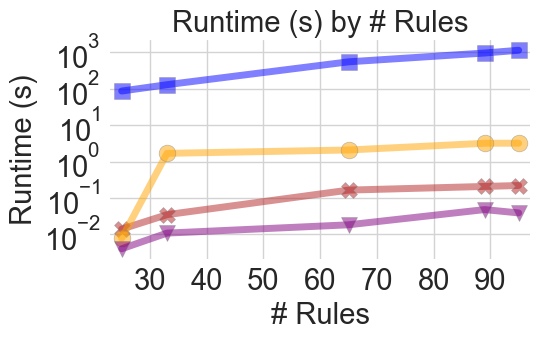

In [57]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams["mathtext.default"] = "regular"

plt.figure(figsize=((5.5, 3.5)))
# Plot the first data on the first subplot
#ax1.plot([61 , 77, 104], y1, color='red')
#ax1.set_title('Plot 1')

x = [25,33,65,89,95]

plt.xlim(x[0]-2, x[-1]+2)

#print(times_MC)

plt.plot(x, times_by_rules,  marker='X', color = "firebrick" , linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
# this is below 

plt.plot(x, all_averages_times_MC, marker='o', color = "orange" ,   linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_GT, marker='v', 
        color = "purple",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_SAT, marker='s', 
        color = "blue",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

#ax1.legend(fontsize = 16)

#ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
plt.title("Runtime (s) by # Rules" , fontsize = 21)

plt.xlabel(" # Rules ", fontsize = 21 )

plt.ylabel(" Runtime (s) " , fontsize = 21 ) 

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(fontsize=21)  # Change the fontsize to your desired value
plt.yticks(fontsize=21)

hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()


plt.savefig("mushroom_1000_runtime_vs_n_rules_with_SAT" +  "_log.pdf") 

# Display the plots
plt.show()


/tmp/ipykernel_138104/1139463111.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
/tmp/ipykernel_138104/1139463111.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])


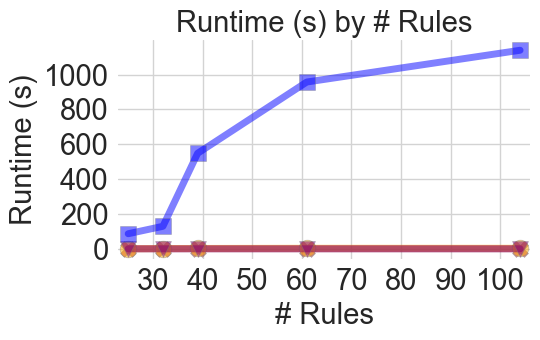

In [58]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams["mathtext.default"] = "regular"

plt.figure(figsize=((5.5, 3.5)))
# Plot the first data on the first subplot
#ax1.plot([61 , 77, 104], y1, color='red')
#ax1.set_title('Plot 1')

x = [25, 32, 39, 61 , 104]

plt.xlim(x[0]-2, x[-1]+2)

#print(times_MC)

plt.plot(x, times_by_rules,  marker='X', color = "firebrick" , linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
# this is below 

plt.plot(x, all_averages_times_MC, marker='o', color = "orange" ,   linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_GT, marker='v', 
        color = "purple",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_times_SAT, marker='s', 
        color = "blue",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

#ax1.legend(fontsize = 16)

#ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
plt.title("Runtime (s) by # Rules" , fontsize = 21)

plt.xlabel(" # Rules ", fontsize = 21 )

plt.ylabel(" Runtime (s) " , fontsize = 21 ) 

#plt.yscale('log')  # Set y-axis to logarithmic scale

plt.xticks(fontsize=21)  # Change the fontsize to your desired value
plt.yticks(fontsize=21)

hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()



plt.savefig("mushroom_1000_runtime_vs_n_rules_with_SAT" +  ".pdf") 

# Display the plots
plt.show()

In [22]:
all_times_SAT

[4213.5168561935425]

In [52]:
times_by_rules

[0.01723320484161377,
 0.02524409294128418,
 0.061905527114868165,
 0.22483701705932618,
 1.074742889404297]

In [35]:
all_n_rules = [25,32,39,61,104]

In [ ]:
import pickle 
pickle.dump(rules, open("rules_compas_" + str(len(rules)), "wb" ))

In [38]:
#from bds.bbSampleTree import BranchAndBoundNaive
import time 
import random
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random

In [77]:
times_by_rules

[0.007017993927001953,
 0.011576223373413085,
 0.019589877128601073,
 0.07739427089691162,
 0.2481606721878052]

In [76]:
results_sampleTree_counts = dict() 
results_sampleTree_times = dict() 
lmbd = 0.1 
ub = 0.3 
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

all_n_rules = [25, 32, 39, 61 , 104]
        

for l in [16]: 
    for k in   [506]: #[100, 225, 506, 1139, 2562, 2562, 5764, 12969, 29180]: #[100, 225, 506, 1139, 2562, 2562, 5764]:
        
        times_by_rules = []
        counts_by_rules = [] 
        
        for n_rules in all_n_rules: 
            
            print(n_rules)
            
            rules = read_pickle("rules/rules_compas_04_" + str(n_rules))[0]

            all_times = [] 
            all_counts = []

            for _ in range(10):
                ts = time.time() 
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k) 
                Z = bb.runST()
                elapsed =  (time.time() - ts) 
                all_times.append(elapsed) 
                all_counts.append(Z) 

            times_by_rules.append(np.mean(all_times)) 
            counts_by_rules.append(np.mean(all_counts))


        pickle.dump(times_by_rules, open("times_by_rules_4_" + str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )
        pickle.dump(counts_by_rules, open("counts_by_rules_4_" + str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )

        

[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230814 20:15:06 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


In [54]:
def read_pickle(filepath_y): 
    objects = []
    with (open(filepath_y, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

    return objects 

In [ ]:
5764 * 1.5**2 * 1.5**2

In [ ]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


for l in [1,2,4,8]: 
    for k in [100, 225, 506, 1139, 2562, 2562,3000, 4000, 5764, 12969, 29180]:
        
        if k > 5765 and l > 2: 
            continue 
        
        times = read_pickle(  "times_by_rules_" + str(104) + "_" + str(l) + "_" + str(k)  )[0]
        counts = read_pickle(  "counts_by_rules_" + str(104) + "_" + str(l) + "_" + str(k)  )[0]
            
        times_MC = [] 
        counts_MC = [] 
        
        times_GT = [] 
        counts_GT = []
        
        for n_rules in [61 , 77, 104]: 
            
            this_times_MC = read_pickle(  "all_averages_times_MC_" + str(n_rules)  )[0]
            
            times_MC.append(this_times_MC[0]) 
            
            this_cnts_MC = read_pickle(  "all_averages_counts_MC_" + str(n_rules)  )[0]
            
            counts_MC.append(this_cnts_MC[0]) 
            
            this_times_GT = read_pickle(  "all_averages_times_GT_" + str(n_rules)    )[0] 
            
            times_GT.append(this_times_GT[0]) 
            
            this_cnts_GT = read_pickle(  "all_averages_counts_GT_" + str(n_rules)    )[0] 
            
            counts_GT.append(this_cnts_MC[0])
            
            
        
        #plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
        mpl.rcParams['axes.facecolor'] = 'white'
        mpl.rcParams['grid.color'] = 'lightgray'
        mpl.rcParams["mathtext.default"] = "regular"
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        # Plot the first data on the first subplot
        #ax1.plot([61 , 77, 104], y1, color='red')
        #ax1.set_title('Plot 1')
        
        x = [61 , 77, 104]
        
        
        #print(times_MC)
        
        ax1.plot(x, times,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        ax1.plot(x, times_MC, marker='o', color = "orange" ,  label = "ApproxMC-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
        ax1.plot(x, times_GT, marker='v', 
                color = "purple", label = "FullBB-RS",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        
        ax1.legend(fontsize = 16)
        
        ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
        
        ax1.set_xlabel(" # Rules ", fontsize = 14 )
        
        ax1.set_ylabel(" Runtime (s) " , fontsize = 14 ) 
        
        ax1.set_yscale('log')  # Set y-axis to logarithmic scale

       
        ax2.plot(x, counts,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        ax2.plot(x, counts_MC, marker='o', color = "orange" , label = "ApproxMC-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
        ax2.plot(x, counts_GT, marker='v', 
                color = "purple",  label = "FullBB-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        
        ax2.legend(fontsize = 16)
        
        
        ax2.set_title('Counts VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16  )
        
         
        ax2.set_xlabel(" # Rules ", fontsize = 14 )
        
        ax2.set_ylabel(" Counts" , fontsize = 14 ) 
       
        ax2.set_yscale('log')  # Set y-axis to logarithmic scale

        
        
        hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
        hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
     #   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
     #   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        #legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
        #legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
        hB.set_visible(False)
        hS.set_visible(False)
        hHP.set_visible(False)

    
        # Adjust spacing between subplots
        plt.tight_layout()
        
        
        
        
        plt.savefig("sample_tree_by_rules_" + str(l) + "_" + str(k) + "_log.pdf") 

        # Display the plots
        plt.show()


        
        
            
        

In [ ]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


for l in [1,4]: 
    for k in [100, 225, 506, 1139, 2562, 5764]:
        
        #if k > 5765 and l > 2: 
        #    continue 
        
        times = read_pickle(  "times_by_rules_2_" + str(312) + "_" + str(l) + "_" + str(k)  )[0]
        counts = read_pickle(  "counts_by_rules_2_" + str(312) + "_" + str(l) + "_" + str(k)  )[0]
            
        times_MC = [] 
        counts_MC = [] 
        
        times_GT = [] 
        counts_GT = []
        
        #for n_rules in all_n_rules: 
            
        times_MC = read_pickle(  "all_averages_times_MC_" + str(312)  )[0]
            
            #"times_MC.append(this_times_MC[0]) 
            
        cnts_MC = read_pickle(  "all_averages_counts_MC_" + str(312)  )[0]
            
           # counts_MC.append(this_cnts_MC[0]) 
            
        times_GT = read_pickle(  "all_averages_times_GT_" + str(312)    )[0] 
            
         #   times_GT.append(this_times_GT[0]) 
            
        cnts_GT = read_pickle(  "all_averages_counts_GT_" + str(312)    )[0] 
            
           # counts_GT.append(this_cnts_MC[0])
            
            
        
        #plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
        mpl.rcParams['axes.facecolor'] = 'white'
        mpl.rcParams['grid.color'] = 'lightgray'
        mpl.rcParams["mathtext.default"] = "regular"
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        # Plot the first data on the first subplot
        #ax1.plot([61 , 77, 104], y1, color='red')
        #ax1.set_title('Plot 1')
        
        all_n_rules = [61, 77, 104, 151, 262, 312]
        
        x = all_n_rules
        
        #print(times_MC)
        
        ax1.plot(x, times,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        ax1.plot(x, times_MC, marker='o', color = "orange" ,  label = "ApproxMC-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
        ax1.plot(x, times_GT, marker='v', 
                color = "purple", label = "FullBB-RS",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        
        ax1.legend(fontsize = 16)
        
        ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
        
        ax1.set_xlabel(" # Rules ", fontsize = 14 )
        
        ax1.set_ylabel(" Runtime (s) " , fontsize = 14 ) 
        
        ax1.set_yscale('log')  # Set y-axis to logarithmic scale

       
        ax2.plot(x, counts,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        ax2.plot(x, cnts_MC, marker='o', color = "orange" , label = "ApproxMC-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
        ax2.plot(x, cnts_GT, marker='v', 
                color = "purple",  label = "FullBB-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

        ax2.legend(fontsize = 16)        
        
        ax2.set_title('Counts VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16  )
        
         
        ax2.set_xlabel(" # Rules ", fontsize = 14 )
        
        ax2.set_ylabel(" Counts" , fontsize = 14 ) 
       
        ax2.set_yscale('log')  # Set y-axis to logarithmic scale

        
        
        hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
        hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        #   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        #   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        #legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
        #legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
        hB.set_visible(False)
        hS.set_visible(False)
        hHP.set_visible(False)

    
        # Adjust spacing between subplots
        plt.tight_layout()
        
                
        plt.savefig("sample_tree_by_rules_3_" + str(l) + "_" + str(k) + "_log.pdf") 

        # Display the plots
        plt.show()


        

In [ ]:
import pandas as pd
import ray
import logging
from bds.meel import approx_mc2, approx_mc2_core
from bds.bb import get_ground_truth_count
from bds.rule import Rule
from bds.utils import bin_random, randints
from logzero import logger

import numpy as np
from contexttimer import Timer

logger.setLevel(logging.WARN)

num_pts = 1000

ub = 0.8
lmbd = .1
delta = .8
eps = .8
show_progres = True
rand_seed = 1234

ray.init(num_cpus=4)

In [ ]:
test_cnt = approx_mc2(
                rules, y, lmbd=lmbd, ub=ub,
                delta=delta, eps=eps, rand_seed=rand_seed, show_progress=show_progres,
                parallel=True, log_level=logging.WARN
            )

In [ ]:
ref_count = get_ground_truth_count(rules, y, lmbd, ub)